# Pre-training
- 学習データの準備
- 言語モデルとは
- ニューラルネットワークを使用しない手法(uni-gram, bi-gram)
- Transformer以前のニューラルネットワークを使用した言語モデル
    - MLP
    - RNN
- Transformerを使用した言語モデル
    - Self-AttentionとFeedforward Networkの実装、並列化
    - GPT-2の実装

プログラミングの解説・エラー解消や用語の解説GPT  
https://chatgpt.com/g/g-H1Baw636t-mlxian-bei

In [1]:
!pip install japanize-matplotlib

## 学習データの準備
ChatGPTのような大規模言語モデルの学習には文書データを大量に集める必要があります。  
データの集め方によってモデルの性能が大きく左右されるので、学習データの準備は重要な工程です。以下に参考になりそうな論文を載せておきます。  
- [Dolma: an Open Corpus of Three Trillion Tokens for Language Model Pretraining Research](https://arxiv.org/abs/2402.00159)  
- [FineWeb: decanting the web for the finest text data at scale](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1)  
- [Data Mixing Laws: Optimizing Data Mixtures by Predicting Language Modeling Performance](https://arxiv.org/abs/2403.16952)  
- [To Code, or Not To Code? Exploring Impact of Code in Pre-training](https://arxiv.org/abs/2408.10914)  
- [Instruction Pre-Training: Language Models are Supervised Multitask Learners](https://arxiv.org/abs/2406.14491)  
- [Textbooks Are All You Need](https://arxiv.org/abs/2306.11644)  
- [Physics of Language Models: Part 3.1, Knowledge Storage and Extraction](https://arxiv.org/abs/2309.14316)  
- [松尾・岩澤研究室で開催したLLM勉強会での発表資料](https://docs.google.com/presentation/d/14SeP11PcgmNcl93Xt0ziSynxdrOVd2WM/edit?usp=sharing&ouid=101802221278095300433&rtpof=true&sd=true)  

今回は[LLM-jpという団体](https://llm-jp.nii.ac.jp/)が整備したコーパスを利用します。
- https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2  

In [2]:
# !wget --no-check-certificate https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2/-/raw/main/ja/ja_wiki/train_9.jsonl.gz
# !wget --no-check-certificate https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2/-/raw/main/ja/ja_wiki/validation_0.jsonl.gz

In [3]:
import gzip
import json

mini_train_data_file_num = 1000
mini_train_data_text = ""
file_count = 0
with gzip.open('train_9.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        mini_train_data_text += data['text'] + "\n"
        file_count += 1
        if file_count == mini_train_data_file_num:
            break
print(data.keys())
print(data['text'][:100])
print(data['meta'])

dict_keys(['text', 'meta'])
チリコシーは、アメリカ合衆国オハイオ州中央部南ロス郡の都市であり、同郡の郡庁所在地である。コロンバス大都市圏に属している。

2010年の国勢調査では人口21,901 人だった。ロス郡では唯一の都市で
{'id': '2973866', 'title': 'チリコシー (オハイオ州)', 'url': 'https://ja.wikipedia.org/wiki/%E3%83%81%E3%83%AA%E3%82%B3%E3%82%B7%E3%83%BC%20%28%E3%82%AA%E3%83%8F%E3%82%A4%E3%82%AA%E5%B7%9E%29'}


In [4]:
val_data_file_num = 1
val_data_text = ""
file_count = 0
with gzip.open('validation_0.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        val_data_text += data['text'] + "\n"
        file_count += 1
        if file_count == val_data_file_num:
            break
print(data.keys())
print(data['text'][:100])
print(data['meta'])

dict_keys(['text', 'meta'])
梶原 一騎（かじわら いっき、1936年9月4日 - 1987年1月21日）は、日本の漫画原作者、小説家、映画プロデューサー。本名は高森 朝樹（たかもり あさき）。高森 朝雄（たかもり あさお）の筆名
{'id': '506', 'title': '梶原一騎', 'url': 'https://ja.wikipedia.org/wiki/%E6%A2%B6%E5%8E%9F%E4%B8%80%E9%A8%8E'}


## 言語モデルとは　　
大規模言語モデルの"言語モデル"とは、単語列の出現確率をモデル化したものです。  
確率を計算できるので、与えられた文章がよく見る文章(確率が高い)なのか、変な文章なのか(確率が低い)を判断することができたり、新たに文章を生成(確率に従ってくじ引きをする)することができます。
より良い言語モデルの開発のためには、データとどのように確率をモデル化するかのデザインが重要です。
### データについて
言語モデルはデータを元に学習するため、そのデータに有益な情報(例えば日本の歴史や法律に関する文章)が含まれていないと、単語自身の理解や単語同士の関係性を学習することができません。  
人間が本を読んだり、人との会話を通じて新しい知識を得たり、良い文章の書き方を学んだりするように、言語モデルもデータを通じて学習します。
### モデル化について
データを得たとしても、どのように確率をモデル化するかのデザインがうまくいかないと、良い言語モデルは作れません。
- データ中の文字を数え上げて前の1単語から次の1単語を予測するモデル
- ニューラルネットワークの一種であるMLPを用いて、前の数単語から次の1単語を予測するモデル
- Transformerを用いて、より長い文脈を考慮して次の単語を予測するモデル  

を開発します。

## ニューラルネットワークを使用しない、数え上げによる手法(uni-gram, bi-gram)の言語モデル

### n-gram 言語モデル
$P\left(w_1, \ldots, w_m\right)=\prod_{i=1}^{i=m} P\left(w_i \mid w_1, \ldots, w_{i-1}\right) \approx \prod_{i=1}^{i=m} P\left(w_i \mid w_{i-n}, \ldots, w_{i-1}\right)$

#### uni-gramモデル
$P\left(w_1, \ldots, w_m\right) \approx \prod_{i=1}^{i=m} P(w_i)$

#### bi-gramモデル  
$P\left(w_1, \ldots, w_m\right)\approx \prod_{i=1}^{i=m} P\left(w_i \mid w_{i-1}\right)$

$P\left(w_{i} \mid w_{i-1}\right)=\frac{\operatorname{count}\left(w_{i}, w_{i-1}\right)}{\operatorname{count}\left(w_{i}\right)}$

In [5]:
print(mini_train_data_text[:100])
print('------------------------')
print('全体の文字数: ', len(mini_train_data_text))
print('文字の種類: ', len(set(mini_train_data_text)))

『勝つか死ぬか』はHBO(日本ではスター・チャンネルが放送)のファンタジー・ドラマ・シリーズである『ゲーム・オブ・スローンズ』の第1章『七王国戦記』の第7話である。プロデューサーでもあるデイヴィッド・
------------------------
全体の文字数:  1569582
文字の種類:  3807


In [6]:
character_count = {}
for character in mini_train_data_text:
    character_count[character] = character_count.get(character, 0) + 1
# 出現頻度の高い文字を上位5個表示
print('出現頻度の高い文字')
print(sorted(character_count.items(), key = lambda kv: -kv[1])[:5])

# 過去の情報を考慮しないuni-gramモデル
print()
total_count = sum(character_count.values())
ch_0 = '日'
ch_1 = '本'
ch_2 = '曜'
print(f"'{ch_0}'の確率 = '{ch_0}'の出現回数 ÷ 全体の文字数 =  {character_count[ch_0]} ÷ {total_count} = {character_count[ch_0] / total_count}")
print(f"'{ch_0 + ch_1}'の確率 = '{ch_0}'の確率 x '{ch_1}'の確率 = {character_count[ch_0] / total_count} x {character_count[ch_1] / total_count} = {character_count[ch_0] * character_count[ch_1] / total_count ** 2}")
print(f"'{ch_0 + ch_2}'の確率 = '{ch_0}'の確率 x '{ch_2}'の確率 = {character_count[ch_0] / total_count} x {character_count[ch_2] / total_count} = {character_count[ch_0] * character_count[ch_2] / total_count ** 2}")

出現頻度の高い文字
[(' ', 53441), ('\n', 44189), ('の', 38675), ('、', 30453), ('ー', 29588)]

'日'の確率 = '日'の出現回数 ÷ 全体の文字数 =  7361 ÷ 1569582 = 0.004689783649404746
'日本'の確率 = '日'の確率 x '本'の確率 = 0.004689783649404746 x 0.001984604818352912 = 9.307367227641361e-06
'日曜'の確率 = '日'の確率 x '曜'の確率 = 0.004689783649404746 x 0.00018093989355127672 = 8.485689543018127e-07


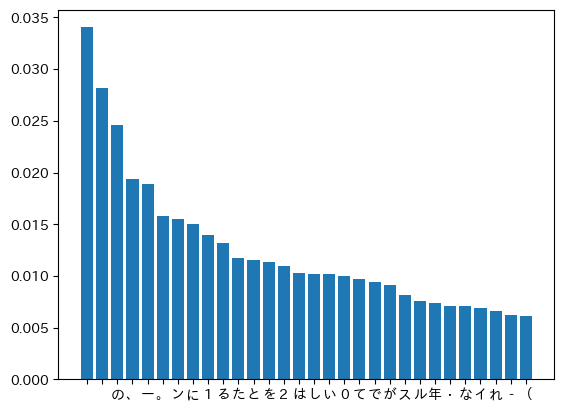

In [7]:
# 出現確率の可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

total_count = sum(character_count.values())
# 上位30文字の出現頻度を取る
top_k = 30
top_k_key = sorted(character_count.keys(), key = lambda k: -character_count[k])[:top_k]
top_k_value = [character_count[k] for k in top_k_key]
top_k_probability = [v / total_count for v in top_k_value]

# x軸に文字、y軸に出現頻度を取る
plt.bar(top_k_key, top_k_probability)
plt.show()

In [8]:
# 生成
# greedy decoding
max_tokens = 20
generated_text = '『勝つか'
for _ in range(max_tokens):
    next_char = max(character_count, key=lambda k: character_count[k]) # 最も出現頻度が高い文字を選択, greedy decoding
    print(repr(next_char))
    generated_text += next_char

print(repr(generated_text))

' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
'『勝つか                    '


In [9]:
# top_p sampling
import random
max_tokens = 20
top_p = 0.9
generated_text = '『勝つか'
for _ in range(max_tokens):
    sorted_character_count = sorted(character_count.items(), key=lambda kv: -kv[1])
    cumulative_probability = 0
    vocab = []
    vocab_count = []
    vocab_total_count = 0
    for character, count in sorted_character_count:
        cumulative_probability += count / total_count
        if cumulative_probability > top_p:
            break
        vocab.append(character)
        vocab_count.append(count)
        vocab_total_count += count
    probablity = [count / vocab_total_count for count in vocab_count]
    next_char = random.choices(vocab, probablity)[0]
    print(repr(next_char))
    generated_text += next_char
print(repr(generated_text))

'シ'
'ト'
'、'
'化'
'任'
'県'
'と'
'定'
'ア'
'位'
'の'
'い'
'っ'
'月'
'L'
'で'
'、'
'ま'
'続'
'H'
'『勝つかシト、化任県と定ア位のいっ月Lで、ま続H'


### Tokenizer
Tokenizerの設計も重要です、以下に参考となるリンクを載せておきます。  
- [Let's build the GPT Tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE)  
- [Scaling Laws with Vocabulary: Larger Models Deserve Larger Vocabularies](https://arxiv.org/abs/2407.13623)  
- [ByT5: Towards a Token-Free Future with Pre-trained Byte-to-Byte Models](https://arxiv.org/abs/2105.13626)  
- GPTシリーズのTokenizer: https://github.com/openai/tiktoken
- Llama2やLLM-jpのtokenizerを作成する際に利用: https://github.com/google/sentencepiece
- Byte Pair Encodingの実装: https://github.com/kenoharada/language-model-from-scratch/blob/main/notebooks/Ja/Tokenizer.ipynb  

In [10]:
unique_chars_in_train_text = sorted(list(set(mini_train_data_text)))

class Tokenizer:
    def __init__(self, chars):
        self.str_to_idx = dict()
        self.str_to_idx['<|endoftext|>'] = 0
        # utf-8
        for i in range(256):
            if f'<utf8_{i}>' not in self.str_to_idx:
                self.str_to_idx[f'<utf8_{i}>'] = len(self.str_to_idx)
        for char in chars:
            self.str_to_idx[char] = len(self.str_to_idx)
        self.idx_to_str = dict()
        for key, value in self.str_to_idx.items():
            self.idx_to_str[value] = key
    
    def encode(self, text, eot=False):
        result = []
        for char in text:
            if char not in self.str_to_idx:
                utf_8_num = list(char.encode("utf-8"))
                for num in utf_8_num:
                    result.append(self.str_to_idx[f'<utf8_{num}>'])
            else:
                result.append(self.str_to_idx[char])
        if eot:
            result.append(self.str_to_idx['<|endoftext|>'])
        return result
    
    def decode(self, tokens):
        decoded_with_utf_token = [self.idx_to_str[token] for token in tokens]
        decoded_postprocess_utf = []
        utf_tokens = []
        for token in decoded_with_utf_token:
            if token.startswith("<utf8_"):
                utf_num = int(token.replace("<utf8_", "").replace(">", ""))
                utf_tokens.append(utf_num)
            else:
                if utf_tokens:
                    decoded_postprocess_utf.append(bytes(utf_tokens).decode("utf-8"))
                    utf_tokens = []
                decoded_postprocess_utf.append(token)
        if utf_tokens:
            decoded_postprocess_utf.append(bytes(utf_tokens).decode("utf-8"))
            utf_tokens = []
        return "".join(decoded_postprocess_utf)
    
    def decode_with_utf(self, tokens):
        return "".join([self.idx_to_str[token] for token in tokens])

tokenizer = Tokenizer(unique_chars_in_train_text) # Tokenizerの初期化、一般的にはByte Pair EncodingやUnigram Language Modelなどを活用してTokenizerを実装する
text = '言語モデルの勉強は楽しいです。'
print(tokenizer.encode(text))

[3310, 3354, 694, 667, 703, 591, 1027, 1621, 592, 2156, 568, 549, 584, 570, 526]


In [11]:
# 学習用データにある語
'日' in unique_chars_in_train_text

True

In [12]:
tokenizer.encode('日'), tokenizer.decode_with_utf([1954]), tokenizer.decode_with_utf([1954])

([1954], '日', '日')

In [13]:
# 学習用データにない未知語
'😄' in unique_chars_in_train_text

False

In [14]:
tokenizer.encode('😄'), tokenizer.decode_with_utf([241, 160, 153, 133]), tokenizer.decode([241, 160, 153, 133])

([241, 160, 153, 133], '<utf8_240><utf8_159><utf8_152><utf8_132>', '😄')

In [15]:
# bi-gramモデル
bigram_count = {}
mini_train_data_tokens = []
mini_train_data_file_num = 1000
mini_train_data_text = ""
file_count = 0

with gzip.open('train_9.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        mini_train_data_tokens += tokenizer.encode(data['text'], eot=True)
        file_count += 1
        if file_count == mini_train_data_file_num:
            break

val_data_tokens = []
val_data_file_num = 1
val_data_text = ""
file_count = 0
with gzip.open('validation_0.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        val_data_tokens += tokenizer.encode(data['text'], eot=True)
        file_count += 1
        if file_count == val_data_file_num:
            break

for i in range(len(mini_train_data_tokens) - 1):
    bigram = (mini_train_data_tokens[i], mini_train_data_tokens[i+1])
    bigram_count[bigram] = bigram_count.get(bigram, 0) + 1

# top-kのbigramを表示
print('出現頻度の高いbigram')
top_k = 10
top_k_bigram = sorted(bigram_count.items(), key = lambda kv: -kv[1])[:top_k]
print(top_k_bigram)
# decodeして確認
for bigram, count in top_k_bigram:
    print(repr(tokenizer.decode([bigram[0]])), repr(tokenizer.decode([bigram[1]])), count)

出現頻度の高いbigram
[((258, 259), 14841), ((526, 258), 10469), ((258, 258), 9382), ((620, 526), 8329), ((277, 275), 7166), ((259, 272), 6726), ((272, 259), 6423), ((576, 526), 5829), ((583, 549), 5599), ((568, 583), 5552)]
'\n' ' ' 14841
'。' '\n' 10469
'\n' '\n' 9382
'る' '。' 8329
'2' '0' 7166
' ' '-' 6726
'-' ' ' 6423
'た' '。' 5829
'て' 'い' 5599
'し' 'て' 5552


In [16]:
# 生成
# greedy decoding
max_tokens = 20
generated_text = '『勝つか'
generated_tokens = tokenizer.encode(generated_text)[:-1]
for _ in range(max_tokens):
    next_token = max(bigram_count, key=lambda k: bigram_count[k] if k[0] == generated_tokens[-1] else 0) # 直前の文字が来たときの次の文字の出現頻度が最も高いものを選択
    generated_tokens.append(next_token[1])
    print(repr(tokenizer.decode([next_token[1]])))
print(generated_tokens)
print(tokenizer.decode(generated_tokens))

'い'
'る'
'。'
'\n'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
[536, 1032, 581, 549, 620, 526, 258, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272]
『勝ついる。
 - - - - - - - -


In [17]:
from collections import defaultdict
import torch
from torch.nn import functional as F
import copy


class Ngram:
    def __init__(self, n, vocab, laplace=1):
        self.n = n
        self.vocab = vocab
        self.laplace = laplace
        self.ngram = defaultdict(lambda: laplace)
        self.context_count = defaultdict(lambda: laplace * len(self.vocab))
    
    def train(self, token_list):
        assert isinstance(token_list, list)
        for i in range(len(token_list) - self.n + 1):
            ngram_list = copy.deepcopy(token_list[i:i+self.n])
            ngram_list = [str(i) for i in ngram_list]
            context = ngram_list[:-1]
            ngram_key = '-'.join(ngram_list)
            context_key = '-'.join(context)
            self.ngram[ngram_key] += 1
            self.context_count[context_key] += 1
    

    def train_batch(self, token_list):
        for tokens in token_list:
            self.train(tokens)
    
    def get_prob(self, ngram):
        if self.n == 1:
            return self.ngram[ngram] / len(self.vocab)
        else:
            context = ngram.split('-')[:-1]
            context = '-'.join(context)
            return self.ngram[ngram] / self.context_count[context]
    
    def get_prob_distribution(self, n_minus_1_gram):
        distribution = []
        distribution_dict = {}
        for word in self.vocab:
            ngram_list = n_minus_1_gram + [word]
            ngram = '-'.join([str(i) for i in ngram_list])
            # print('hi', ngram)
            distribution.append(self.get_prob(ngram))
            distribution_dict[word] = self.get_prob(ngram)
        return distribution, distribution_dict
    
    def forward(self, token_indexes):
        # token_indexes: (batch_size, sequence_length)
        if isinstance(token_indexes, torch.Tensor) or isinstance(token_indexes, torch.LongTensor):
            token_indexes = token_indexes.tolist()
        assert isinstance(token_indexes, list)
        batch_size = len(token_indexes)
        sequence_length = len(token_indexes[0])
        distributions = torch.ones(batch_size, sequence_length, len(self.vocab))
        distributions /= len(self.vocab)
        for i in range(sequence_length):
            for batch in range(batch_size):
                if self.n == 2:
                    context = [token_indexes[batch][i]]
                else:
                    if i < self.n - 1:
                        if i == 0:
                            context = [token_indexes[batch][i]]
                        else:
                            context = token_indexes[batch][:i+1]
                    else:
                        context = token_indexes[batch][i-self.n+2:i+1]
                distribution, _ = self.get_prob_distribution(context)
                distributions[batch, i] = torch.tensor(distribution)
        # distributions: (batch_size, sequence_length, vocab_size)
        return distributions
    
    def loss(self, token_indexes, targets):
        # token_indexes: (batch_size, sequence_length)
        # targets: (batch_size, sequence_length)
        distributions = self.forward(token_indexes)
        distributions = distributions.to(targets.device)
        log_distributions = torch.log(distributions)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = log_distributions.shape
        loss = F.nll_loss(
            log_distributions.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_length=10):
        # token_indexes: (batch_size, sequence_length)
        for _ in range(max_length):
            distributions = self.forward(token_indexes)
            distributions = distributions[0, -1]
            # greedy decoding
            next_token = torch.argmax(distributions).item()
            token_indexes[0].append(next_token)
        return token_indexes

In [18]:
n = 2
parameters = len(tokenizer.str_to_idx) ** n
print(f'パラメータ数: {parameters}')

パラメータ数: 16516096


In [19]:
ngram = Ngram(2, tokenizer.str_to_idx.values())
ngram.train(mini_train_data_tokens)
generated_text = '『勝つか'
context_token_indexes = [tokenizer.encode(generated_text)]
generated_tokens = ngram.generate(context_token_indexes, max_length=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token])))

'『'
'勝'
'つ'
'か'
'ら'
'れ'
'た'
'。'
'\n'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '


In [20]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1:context_length+1]
ngram.loss([input_tokens], torch.tensor([target_tokens])).item()

5.082467079162598

In [21]:
ngram = Ngram(4, tokenizer.str_to_idx.values())
ngram.train(mini_train_data_tokens)
generated_text = '『勝つか'
context_token_indexes = [tokenizer.encode(generated_text)[:-1]]
generated_tokens = ngram.generate(context_token_indexes, max_length=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token])))

'『'
'勝'
'つ'
'か'
'死'
'ぬ'
'か'
'』'
'は'
'H'
'B'
'O'
'('
'日'
'本'
'で'
'は'
'ス'
'タ'
'ー'
'・'
'ウ'
'ォ'


In [22]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1:context_length+1]
ngram.loss([input_tokens], torch.tensor([target_tokens])).item()

7.280468463897705

## ニューラルネットワークを使用した言語モデル　　
言語モデルをデザインする際に、過去の文脈を考慮するとより自然な文章のモデリングができると考えられます。  
ただ、N-gramモデルのパラメータ数のオーダーは、$O\left(\left|V\right|^n\right)$　となり、過去の文脈が増えれば増えるほど組み合わせが膨大になります。  
組み合わせ単位で数え上げているため、データ中に出現しない組み合わせがあると、その組み合わせの確率は0となり、その後の予測ができなくなってしまいます。  

また、組み合わせ別の数え上げでは、単語・文脈をそれぞれ独立したものとして扱っており、単語の意味や文脈を共有した表現が得られません。

解決策として組み合わせの表によるモデル化ではなく、ニューラルネットワークと単語ベクトルの表現を用いることでモデル化を行います。

ニューラルネットワークの学習の際に行う、次単語予測によって単語ベクトルには単語の意味や概念が付与され、ニューラルネットワークのパラメータには単語同士の関係性が学習されることが期待されます。

日本で最も高い山は「？」の？を当てるために、
- ？には文法的に名詞が入る
- その候補は文脈的に山であり
- 日本で最も高いという情報がある、というような文脈上のどの情報に着目するか
- 文脈を踏まえた上で今まで得た知識をどのように組み合わせるか

ということをニューラルネットワークが学習します。

### MLPによるモデル化

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff):
        super().__init__()
        # 単語ベクトルの取得
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        # FeedForward Layer
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
            )
        # vocab_sizeへの変換
        self.linear = nn.Linear(d_model, vocab_size)
        print('number of parameters:', sum(p.numel() for p in self.parameters()))
    
    def forward(self, token_indexes):
        # token_index: (batch_size, sequence_length)
        embedding = self.token_embedding_table(token_indexes)
        logits = self.linear(self.ff(embedding))
        # logits: (batch_size, sequence_length, vocab_size)
        return logits

    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length),
            reduction='none'
            )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)
    
    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            # greedy decoding
            next_token = torch.argmax(next_token_probs, dim=-1, keepdim=True)
            # next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes

In [24]:
vocab_size = len(tokenizer.str_to_idx)
d_model = 4
d_ff = d_model * 4
nn_lm = BigramLanguageModel(vocab_size, d_model, d_ff)

number of parameters: 36724


In [25]:
text = '『勝つか'
token_indexes = torch.tensor([tokenizer.encode(text)])
input_token_indexes = token_indexes[:, :-1]
target_token_indexes = token_indexes[:, 1:]
print(input_token_indexes)
print(tokenizer.decode(input_token_indexes[0].tolist()))

print(target_token_indexes)
print(tokenizer.decode(target_token_indexes[0].tolist()))

tensor([[ 536, 1032,  581]])
『勝つ
tensor([[1032,  581,  556]])
勝つか


In [26]:
token_embeddings = nn_lm.token_embedding_table(input_token_indexes)
print(token_embeddings)

tensor([[[ 0.4086, -1.4731,  0.8040, -0.1425],
         [-0.8011,  0.0812, -1.1384, -0.4476],
         [ 1.3060, -1.2617, -0.0670,  0.2999]]], grad_fn=<EmbeddingBackward0>)


In [27]:
nn_lm.generate(token_indexes, 10)

tensor([[ 536, 1032,  581,  556, 3504, 2662, 2686, 1259, 1436, 2741, 1904, 1904,
         1904, 1904]])

In [28]:
template = """入力: {input_text} → Token id: {input_token_id} → Token embedding: {token_embeddings} 
→ Neural Net → 
{next_token_prediction_prob} <---学習によって近づける---> Target: {target_prob}"""
for idx, token in enumerate(input_token_indexes[0]):
    input_text = tokenizer.decode([input_token_indexes[0].tolist()[idx]])
    input_token_id = token.item()
    token_embeddings = nn_lm.token_embedding_table(token.unsqueeze(0)).squeeze().detach().numpy().tolist()
    next_token_prediction = nn_lm(token.unsqueeze(0))
    next_token_prediction = F.softmax(next_token_prediction, dim=-1)
    next_token_prediction_top_k_index = torch.topk(next_token_prediction, 3).indices

    target_token_id = target_token_indexes[0][idx].item()
    pickup_token_indexes = [target_token_id] + next_token_prediction_top_k_index[0].tolist()
    next_token_prediction_prob = next_token_prediction[0][pickup_token_indexes].tolist()
    next_token_prediction_prob_text = [f'{token_id}: {prob:.3f}' for token_id, prob in zip(pickup_token_indexes, next_token_prediction_prob)]
    next_token_prediction_prob = ', '.join(next_token_prediction_prob_text)
    target_token_distribution = F.one_hot(target_token_indexes[0][idx], num_classes=vocab_size)[pickup_token_indexes].tolist()
    target_token_distribution = [f'{token_id}: {prob}' for token_id, prob in zip(pickup_token_indexes, target_token_distribution)]
    target_token_distribution = ', '.join(target_token_distribution)
    print(template.format(input_text=input_text, input_token_id=input_token_id, token_embeddings=token_embeddings, next_token_prediction_prob=next_token_prediction_prob, target_prob=target_token_distribution))
    break

入力: 『 → Token id: 536 → Token embedding: [0.40859851241111755, -1.4730736017227173, 0.8040308952331543, -0.1425115317106247] 
→ Neural Net → 
1032: 0.000, 1436: 0.000, 2776: 0.000, 1259: 0.000 <---学習によって近づける---> Target: 1032: 1, 1436: 0, 2776: 0, 1259: 0


In [29]:
# 学習
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_lm = BigramLanguageModel(vocab_size, d_model, d_ff).to(device)
optimizer = torch.optim.AdamW(nn_lm.parameters(), lr=1e-3)

batch_size = 512
epochs = 1
training_tokens = 0
print('before training')
val_loss = 0
for i in range(0, len(val_data_tokens), batch_size):
    batch_tokens = val_data_tokens[i:i+batch_size]
    input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
    target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
    with torch.no_grad():
        loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
    val_loss += loss.sum().item()
val_loss = val_loss / len(val_data_tokens)
print(f'val_loss: {val_loss}')
print('start training')
for epoch in range(epochs):
    for i in range(0, len(mini_train_data_tokens), batch_size):
        batch_tokens = mini_train_data_tokens[i:i+batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        loss = nn_lm.loss(input_token_indexes, target_token_indexes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_tokens += len(batch_tokens)
        if training_tokens % 10000 == 0:
            print(f'epoch: {epoch}, loss: {loss.item()}, training_tokens: {training_tokens}')
    val_loss = 0
    for i in range(0, len(val_data_tokens), batch_size):
        batch_tokens = val_data_tokens[i:i+batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        with torch.no_grad():
            loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
        val_loss += loss.sum().item()
    val_loss = val_loss / len(val_data_tokens)
    print(f'epoch: {epoch}, val_loss: {val_loss}')

number of parameters: 36724
before training
val_loss: 8.358726854722773
start training
epoch: 0, loss: 6.001175403594971, training_tokens: 320000
epoch: 0, loss: 5.794539928436279, training_tokens: 640000
epoch: 0, loss: 6.049036502838135, training_tokens: 960000
epoch: 0, loss: 5.6892499923706055, training_tokens: 1280000
epoch: 0, val_loss: 6.137528019963166


In [30]:
context = '『勝つか'
context_token_indexes = torch.tensor(tokenizer.encode(context)).unsqueeze(0).to(device)
generated_tokens = nn_lm.generate(context_token_indexes, max_new_tokens=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token.item()])))

'『'
'勝'
'つ'
'か'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'
' '
'\n'


In [31]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1:context_length+1]
input_token_indexes = torch.tensor(input_tokens).unsqueeze(0).to(device)
target_token_indexes = torch.tensor(target_tokens).unsqueeze(0).to(device)
nn_lm.loss(input_token_indexes, target_token_indexes).item()

# bi-gram(パラメータ数 16516096)の性能: 5.082467079162598

6.028300762176514

In [32]:
import math
# 当てずっぽうモデルのloss
vocab_size = len(tokenizer.str_to_idx)
print('vocab_size', vocab_size)
print(-math.log(1/len(tokenizer.str_to_idx.values())))

math.exp(6.014070987701416), math.exp(2.0) # Understanding Emergent Abilities of Language Models from the Loss Perspective, https://arxiv.org/abs/2403.15796

vocab_size 4064
8.309922989258318


(409.1455610444513, 7.38905609893065)

#### 演習1: MLPの層を増やしたり、学習率などを変更して未来の単語の予測精度向上を試みる、過去のNトークンを入力とするモデルを構築してみよう

In [33]:
# WRITE ME

言語ベクトルとMLPによるモデル化によって
- 密な言語ベクトル表現によって、単語の意味や概念を表現
- パラメータ数がO(exp(n))からO(n)へと削減

残る課題
- 見れる過去の文脈長が固定、増やそうとするとパラメータ数が増加

### RNNによるモデル化

In [34]:
import torch

vocab = {'あ': 0, 'い': 1, 'う':2, 'え':3, 'お':4, '<|endoftext|>':5}
idx_to_ch = dict((v, k) for (k,v) in vocab.items())
text = 'いええい'
text = list(text) + ['<|endoftext|>']
text = [vocab[ch] for ch in text]
model_input = torch.tensor(text[:-1])
model_target = torch.tensor(text[1:])
print('model input', model_input.tolist(), [idx_to_ch[idx] for idx in model_input.tolist()])
print('model target', model_target.tolist(), [idx_to_ch[idx] for idx in model_target.tolist()])

model input [1, 3, 3, 1] ['い', 'え', 'え', 'い']
model target [3, 3, 1, 5] ['え', 'え', 'い', '<|endoftext|>']


In [35]:
# RNNの定義
vocab_size = len(vocab)
embedding_dim = 5
hidden_dim = 3
hidden_start = torch.zeros((1, hidden_dim)).T
word_embedding_table = torch.randn((vocab_size, embedding_dim))

We = torch.randn((hidden_dim, embedding_dim))
Wh = torch.randn((hidden_dim, hidden_dim))
Wy = torch.randn((vocab_size, hidden_dim))

In [36]:
# RNNの順伝播の計算の様子
h_t_minus_1 = hidden_start
input_history = []

# 前のステップの計算が次のステップの計算に影響するため並列化が難しい。
# RNNの計算複雑度 len(model_input.tolist()) * hidden_dim * hidden_dim = T * d * d
for t in range(len(model_input.tolist())):
    idx = model_input.tolist()[t]
    input_history.append(idx_to_ch[idx])
    print(input_history, '----> RNN ----> ', idx_to_ch[model_target.tolist()[t]])
    x = torch.LongTensor([idx])
    x = word_embedding_table[x].T
    # Attentionを導入したいポイント、過去の文脈がh_t_minus_1に押し込まれる
    # ネットワークが単語方向に深くなるため学習が不安定に
    # d * d, 系列長によらず一定
    h_t = torch.tanh(torch.matmul(We, x) + torch.matmul(Wh, h_t_minus_1))
    logits = torch.matmul(Wy, h_t)
    print(f'P({idx_to_ch[model_target.tolist()[t]]} | {", ".join(input_history)}) = {torch.softmax(logits, dim=0).squeeze().tolist()[model_target.tolist()[t]]:.3f}')
    model_target_onehot = torch.zeros((1, vocab_size))
    model_target_onehot[0, model_target.tolist()[t]] = 1
    h_t_minus_1 = h_t
    output_dist = [float('{:.3f}'.format(output)) for output in torch.softmax(logits, dim=0).squeeze().tolist()]
    print(f'{output_dist} <-----学習によって近づける-----> {model_target_onehot.tolist()[0]}')
    print()

['い'] ----> RNN ---->  え
P(え | い) = 0.025
[0.048, 0.178, 0.208, 0.025, 0.432, 0.109] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

['い', 'え'] ----> RNN ---->  え
P(え | い, え) = 0.220
[0.409, 0.123, 0.051, 0.22, 0.096, 0.101] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

['い', 'え', 'え'] ----> RNN ---->  い
P(い | い, え, え) = 0.137
[0.091, 0.137, 0.122, 0.277, 0.148, 0.224] <-----学習によって近づける-----> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

['い', 'え', 'え', 'い'] ----> RNN ---->  <|endoftext|>
P(<|endoftext|> | い, え, え, い) = 0.119
[0.028, 0.163, 0.219, 0.023, 0.448, 0.119] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]



RNNによるモデル化によって
- 文脈長を固定せずに、任意の長さの文脈を考慮
- 文脈長が増えてもパラメータ数が増えない

残る課題
- 学習が不安定(勾配消失、勾配爆発)
- 並列化ができず、学習が遅い
- 文脈長が長くなるとトークンの長距離依存関係の把握が難しくなる。

#### 演習2: RNNで学習、生成してみよう

In [37]:
# WRITE ME

### Transformerによるモデル化と学習

Attention $(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$

Attention Is All You Needの式(1)より

In [38]:
batch_size = 1
sequence_length = 4
d_head = 2

K = torch.randn(batch_size, sequence_length, d_head)
Q = torch.randn(batch_size, sequence_length, d_head)
V = torch.randn(batch_size, sequence_length, d_head)

qk_dot_product = Q @ K.transpose(-2, -1)
scaled_qk_dot_product = qk_dot_product / (d_head ** 0.5)

attention_scores = torch.softmax(scaled_qk_dot_product, dim=-1)
attention_output = attention_scores @ V

attention_scores_without_scale = torch.softmax(qk_dot_product, dim=-1)
attention_output_without_scale = attention_scores_without_scale @ V

In [39]:
qk_dot_product.var(), scaled_qk_dot_product.var()

(tensor(0.6550), tensor(0.3275))

In [40]:
attention_scores.shape

torch.Size([1, 4, 4])

In [41]:
attention_scores[:, -1, :], attention_scores[:, -1, :].sum()

(tensor([[0.1064, 0.2228, 0.2430, 0.4278]]), tensor(1.))

In [42]:
attention_scores[:, -1, :], attention_scores_without_scale[:, -1, :]

(tensor([[0.1064, 0.2228, 0.2430, 0.4278]]),
 tensor([[0.0704, 0.2000, 0.2262, 0.5034]]))

$\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$  
Attention Is All You Needの式(2)より

```python
# MLPでの実装の際に実装
self.ff = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Linear(d_ff, d_model)
)
```

In [43]:
import torch

# GPT-2 Small
vocab_size = 50257
d_model = embedding_dim = 768 
d_ff = d_model * 4
n_head = 12 
n_layer = 12
d_k = int(d_model / n_head)
d_v = int(d_model / n_head)

word_embedding_table = torch.randn((vocab_size, embedding_dim))

Wq = torch.randn((d_k, embedding_dim))
Wk = torch.randn((d_k, embedding_dim))

Wv = torch.randn((d_v, embedding_dim))
Wo = torch.randn((d_model, d_v * n_head))

Wff_1 = torch.randn((d_ff, d_model))
Wff_2 = torch.randn((d_model, d_ff))
Wy = torch.randn((vocab_size, d_model))

params_embedding = vocab_size * embedding_dim
print('embddingのパラメータ数', params_embedding)

params_positional_embedding = d_model * 1024
print('positional embeddingのパラメータ数', params_positional_embedding)

params_self_attention = (d_model * d_k * n_head * 2 + d_model * d_v * n_head + d_model * d_v * n_head) * n_layer
print('self-attentionのパラメータ数', params_self_attention)

params_ff = (d_ff * d_model * 2) * n_layer
print('feed-forwardのパラメータ数', params_ff)

total_params = params_positional_embedding + params_embedding + params_self_attention + params_ff # + params_unembedding weight tied
print('合計パラメータ数', total_params)

# パラメータ数の内訳割合
print('embeddingの割合', params_embedding / total_params)
print('positional embeddingの割合', params_positional_embedding / total_params)
print('self-attentionの割合', params_self_attention / total_params)
print('feed-forwardの割合', params_ff / total_params)

embddingのパラメータ数 38597376
positional embeddingのパラメータ数 786432
self-attentionのパラメータ数 28311552
feed-forwardのパラメータ数 56623104
合計パラメータ数 124318464
embeddingの割合 0.31047178961284466
positional embeddingの割合 0.006325946884285829
self-attentionの割合 0.22773408783428983
feed-forwardの割合 0.45546817566857967


In [44]:
import torch

# 1層のFFとAttentionのみのモデル
vocab_size = len(vocab)
d_model = embedding_dim = 3
d_ff = d_model * 4
n_head = 1 
n_layer = 1 
d_k = int(d_model / n_head)
d_v = int(d_model / n_head)

word_embedding_table = torch.randn((vocab_size, embedding_dim))

Wq = torch.randn((d_k, embedding_dim))
Wk = torch.randn((d_k, embedding_dim))

Wv = torch.randn((d_v, embedding_dim))
Wo = torch.randn((d_model, d_v * n_head))

Wff_1 = torch.randn((d_ff, d_model))
Wff_2 = torch.randn((d_model, d_ff))
Wy = torch.randn((vocab_size, d_model))

params_embedding = vocab_size * embedding_dim
print('embddingのパラメータ数', params_embedding)

params_positional_embedding = d_model * 1024
print('positional embeddingのパラメータ数', params_positional_embedding)

params_self_attention = (d_model * d_k * n_head * 2 + d_model * d_v * n_head + d_model * d_v * n_head) * n_layer
print('self-attentionのパラメータ数', params_self_attention)

params_ff = (d_ff * d_model * 2) * n_layer
print('feed-forwardのパラメータ数', params_ff)

total_params = params_positional_embedding + params_embedding + params_self_attention + params_ff # + params_unembedding weight tied
print('合計パラメータ数', total_params)

# パラメータ数の内訳割合
print('embeddingの割合', params_embedding / total_params)
print('positional embeddingの割合', params_positional_embedding / total_params)
print('self-attentionの割合', params_self_attention / total_params)
print('feed-forwardの割合', params_ff / total_params)

embddingのパラメータ数 18
positional embeddingのパラメータ数 3072
self-attentionのパラメータ数 36
feed-forwardのパラメータ数 72
合計パラメータ数 3198
embeddingの割合 0.005628517823639775
positional embeddingの割合 0.9606003752345216
self-attentionの割合 0.01125703564727955
feed-forwardの割合 0.0225140712945591


In [45]:
# 並列化されていないSelf-Attention層、FeedForward層の計算
quries = []
keys = []
values = []
attention_scores = []
attention_outputs = []
input_history = []

# Self-Attentionの計算複雑度 len(model_input.tolist()) * len(model_input.tolist()) * d_model = T * T * d
for t in range(len(model_input.tolist())):
    idx = model_input.tolist()[t]
    input_history.append(idx_to_ch[idx])
    x = torch.LongTensor([idx])
    x = word_embedding_table[x].T # + positional_encodings
    
    # single-head, multi-headになると複数の観点でquery, key, valueの発行をする
    query_t = torch.matmul(Wq, x) # 〇〇探してます！ 例: token_0: 自分主語です、目的語とか助詞とか動詞とか探してます！

    key_t = torch.matmul(Wk, x) # 〇〇持ってます！ 例: token_0: 自分主語です！ token_1: 自分動詞です!
    value_t = torch.matmul(Wv, x) # 中身の詳細です！ 例: token_0: 「拙者」です、珍しい1人称です、お侍さんとかが使ったりします token_1: 「食べる」です、食べ物を口に入れる行為です
    
    # cross attentionの場合はkey, valueは
    # key_t = torch.matmul(Wk, another_modality_x)
    # value_t = torch.matmul(Wv, another_modality_x)のようになる

    quries.append(query_t)
    keys.append(key_t)
    values.append(value_t)
    # Day2の演習では文章単位でベクトル化したqueryとkeyの内積(類似度)をもとにRetrievalを行った
    # 計算複雑度 T * d、系列長によって変化
    # 遠く離れた過去の文脈を考慮できる、入力データに応じて相互作用し、その結果が後の深い層でも反映される
    attention_score = torch.matmul(query_t.T, torch.stack(keys)) / torch.sqrt(torch.tensor(d_k))
    attention_score = torch.softmax(attention_score, dim=0)
    attention_scores.append(attention_score.squeeze())
    self_attention_output = 0
    for i in range(len(attention_score)):
        # query、keyのコミュニケーションの結果がvalueに反映される(attention scoreで重み付け)
        self_attention_output += attention_score[i] * values[i]
    attention_outputs.append(self_attention_output)

    # FeedForwardの計算
    ff_output = torch.matmul(Wff_2, torch.relu(torch.matmul(Wff_1, self_attention_output)))
    # 次単語予測、タスク特化のための分類器を作るような場合には新しくWyを用意して学習する
    logits = torch.matmul(Wy, ff_output)
    output_dist = [float('{:.3f}'.format(output)) for output in torch.softmax(logits, dim=0).squeeze().tolist()]
    
    print(f'P({idx_to_ch[model_target.tolist()[t]]} | {", ".join(input_history)}) = {torch.softmax(logits, dim=0).squeeze().tolist()[model_target.tolist()[t]]:.3f}')
    model_target_onehot = torch.zeros((1, vocab_size))
    model_target_onehot[0, model_target.tolist()[t]] = 1
    print(f'{output_dist} <-----学習によって近づける-----> {model_target_onehot.tolist()[0]}')
    print()

P(え | い) = 0.000
[0.01, 0.0, 0.989, 0.0, 0.001, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

P(え | い, え) = 0.000
[0.003, 0.0, 0.997, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

P(い | い, え, え) = 0.000
[0.002, 0.0, 0.998, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

P(<|endoftext|> | い, え, え, い) = 0.000
[0.002, 0.0, 0.997, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]



In [46]:
# attentionの可視化
attention_map = torch.zeros((len(model_input.tolist()), len(model_input.tolist())))
for t in range(len(model_input.tolist())):
    attention_map[t][:t+1] = attention_scores[t]
    print('token', input_history)
    print(input_history[t], attention_map[t].tolist())
    print('-----' * 20)


token ['い', 'え', 'え', 'い']
い [1.0, 0.0, 0.0, 0.0]
----------------------------------------------------------------------------------------------------
token ['い', 'え', 'え', 'い']
え [0.43965405225753784, 0.5603459477424622, 0.0, 0.0]
----------------------------------------------------------------------------------------------------
token ['い', 'え', 'え', 'い']
え [0.2817670404911041, 0.35911649465560913, 0.35911649465560913, 0.0]
----------------------------------------------------------------------------------------------------
token ['い', 'え', 'え', 'い']
い [0.20397628843784332, 0.29602372646331787, 0.29602372646331787, 0.20397628843784332]
----------------------------------------------------------------------------------------------------


In [47]:
# 未来の情報を用いないようにCausal Attentionを用いて並列化(行列の計算にする)
input_ids = model_input.tolist()
x = torch.LongTensor([input_ids])
x = word_embedding_table[x] # + positional_encodings
# print(x.shape) # (1, T, embedding_dim)

queries = torch.matmul(x.squeeze(), Wq.T) # (T, d_k)
keys = torch.matmul(x.squeeze(), Wk.T) # (T, d_k)
values = torch.matmul(x.squeeze(), Wv.T) # (T, d_v)
# print(queries.shape, keys.shape, values.shape)

attention_scores = torch.matmul(queries, keys.T) / torch.sqrt(torch.tensor(d_k)) # (T, T)
# causal attention、未来の情報を用いないようにする
attention_mask = torch.tril(torch.ones((len(model_input.tolist()), len(model_input.tolist())))) # (T, T)
attention_scores = attention_scores.masked_fill(attention_mask==0, float('-inf'))

attention_scores = torch.softmax(attention_scores, dim=1) # (T, T)
attention_outputs = torch.matmul(attention_scores, values) # (T, d_v)

# FeedForwardの計算
ff_output = torch.matmul(torch.relu(torch.matmul(attention_outputs, Wff_1.T)), Wff_2.T) # (T, d_model)
# print(ff_output.shape)
# 次単語予測
logits = torch.matmul(ff_output, Wy.T) # (T, vocab_size)
output_dists = torch.softmax(logits, dim=1) # (T, vocab_size)

for step_t, output_dist in enumerate(output_dists):
    print(f'P({idx_to_ch[model_target.tolist()[step_t]]} | {", ".join(input_history[:step_t + 1])}) = {output_dist[model_target.tolist()[step_t]]:.3f}')
    model_target_onehot = torch.zeros((1, vocab_size))
    model_target_onehot[0, model_target.tolist()[step_t]] = 1
    print(f'{[float("{:.3f}".format(output)) for output in output_dist.tolist()]} <-----学習によって近づける-----> {model_target_onehot.tolist()[0]}')
    print()


P(え | い) = 0.000
[0.01, 0.0, 0.989, 0.0, 0.001, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

P(え | い, え) = 0.000
[0.003, 0.0, 0.997, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

P(い | い, え, え) = 0.000
[0.002, 0.0, 0.998, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

P(<|endoftext|> | い, え, え, い) = 0.000
[0.002, 0.0, 0.997, 0.0, 0.0, 0.0] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]



In [48]:
attention_scores = torch.matmul(queries, keys.T) / torch.sqrt(torch.tensor(d_k)) # (T, T)
print('causal attention前')
print(attention_scores)
# causal attentionの場合はattention_maskを用いて未来の情報をマスクする
attention_mask = torch.tril(torch.ones((len(model_input.tolist()), len(model_input.tolist())))) # (T, T)
# 下三角行列で未来の情報をマスク
print(attention_mask)
# 未来の情報はscoreが0になるように-infを代入(softmaxで0になる)
attention_scores = attention_scores.masked_fill(attention_mask==0, float('-inf'))
print('causal attention後')
print(attention_scores)
attention_scores = torch.softmax(attention_scores, dim=1) # (T, T)
print('softmax後')
print(attention_scores)

causal attention前
tensor([[ 0.6740,  1.0464,  1.0464,  0.6740],
        [-0.4587, -0.2161, -0.2161, -0.4587],
        [-0.4587, -0.2161, -0.2161, -0.4587],
        [ 0.6740,  1.0464,  1.0464,  0.6740]])
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
causal attention後
tensor([[ 0.6740,    -inf,    -inf,    -inf],
        [-0.4587, -0.2161,    -inf,    -inf],
        [-0.4587, -0.2161, -0.2161,    -inf],
        [ 0.6740,  1.0464,  1.0464,  0.6740]])
softmax後
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4397, 0.5603, 0.0000, 0.0000],
        [0.2818, 0.3591, 0.3591, 0.0000],
        [0.2040, 0.2960, 0.2960, 0.2040]])


In [49]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1234)

class Head(nn.Module):
    def __init__(self, d_model, d_head):
        super().__init__()
        self.key = nn.Linear(d_model, d_head, bias=False)
        self.query = nn.Linear(d_model, d_head, bias=False)
        self.value = nn.Linear(d_model, d_head, bias=False)
        self.back_to_d_model = nn.Linear(d_head, d_model)
        
    
    def forward(self, x):
        # x: (batch_size, sequence_length, d_model)
        B, T, d_model = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        qk_dot_product = q @ k.transpose(-2, -1) / (d_head ** 0.5)
        mask = torch.tril(torch.ones((T, T))).to(qk_dot_product.device)
        qk_dot_product = qk_dot_product.masked_fill(mask == 0, float('-inf'))
        attention_score = torch.softmax(qk_dot_product, dim=-1)
        out = attention_score @ v
        out = self.back_to_d_model(out)
        return out


class AttentionLM(nn.Module):
    def __init__(self, vocab_size, sequence_length, d_model, d_head):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(sequence_length, d_model)
        self.head = Head(d_model, d_head)
        self.unembed = nn.Linear(d_model, vocab_size)
        print('number of parameters:', sum(p.numel() for p in self.parameters()))
    
    
    def forward(self, token_indexes):
        # token_indexes: (batch_size, sequence_length)
        B, T = token_indexes.size()
        token_embed = self.embed(token_indexes)
        pos_embed = self.pos_embed(torch.arange(T).to(token_embed.device))
        x = token_embed + pos_embed
        x = self.head(x)
        logits = self.unembed(x)

        return logits
    
    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length),
            reduction='none'
            )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)
    
    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = len(tokenizer.str_to_idx)
d_model = 4
d_head = 4
sequence_length = 512
attention_lm = AttentionLM(vocab_size, sequence_length, d_model, d_head).to(device)

number of parameters: 38692


In [51]:
mini_train_data_tokens = []
mini_train_data_file_num = 1000
mini_train_data_text = ""
file_count = 0

with gzip.open('train_9.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        mini_train_data_tokens += tokenizer.encode(data['text'], eot=True)
        file_count += 1
        if file_count == mini_train_data_file_num:
            break

val_data_tokens = []
val_data_file_num = 1
val_data_text = ""
file_count = 0
with gzip.open('validation_0.jsonl.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        val_data_tokens += tokenizer.encode(data['text'], eot=True)
        file_count += 1
        if file_count == val_data_file_num:
            break

In [52]:
# 学習
optimizer = torch.optim.AdamW(attention_lm.parameters(), lr=1e-3)

batch_size = 1
epochs = 1
training_tokens = 0
print('before training')
val_loss = 0
for i in range(0, len(val_data_tokens), sequence_length+1):
    batch_tokens = val_data_tokens[i:i+sequence_length+1]
    input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
    target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
    with torch.no_grad():
        loss = attention_lm.loss_per_token(input_token_indexes, target_token_indexes)
    val_loss += loss.sum().item()
val_loss = val_loss / len(val_data_tokens)
print(f'val_loss: {val_loss}')
print('start training')
for epoch in range(epochs):
    for i in range(0, len(mini_train_data_tokens), sequence_length+1):
        batch_tokens = mini_train_data_tokens[i:i+sequence_length+1]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        loss = attention_lm.loss(input_token_indexes, target_token_indexes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_tokens += len(batch_tokens)
        if training_tokens % ((sequence_length+1)*1000) == 0:
            print(f'epoch: {epoch}, loss: {loss.item()}, training_tokens: {training_tokens}')
    val_loss = 0
    for i in range(0, len(val_data_tokens), sequence_length+1):
        batch_tokens = val_data_tokens[i:i+sequence_length+1]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        with torch.no_grad():
            loss = attention_lm.loss_per_token(input_token_indexes, target_token_indexes)
        val_loss += loss.sum().item()
    val_loss = val_loss / len(val_data_tokens)
    print(f'epoch: {epoch}, val_loss: {val_loss}')

before training
val_loss: 8.342648007167377
start training
epoch: 0, loss: 6.0860748291015625, training_tokens: 513000
epoch: 0, loss: 5.641589164733887, training_tokens: 1026000
epoch: 0, loss: 5.4656662940979, training_tokens: 1539000
epoch: 0, val_loss: 6.292435605969679


In [53]:
context_length = 512
input_tokens =  mini_train_data_tokens[:context_length]
target_tokens = mini_train_data_tokens[1:context_length+1]
input_token_indexes = torch.tensor(input_tokens).unsqueeze(0).to(device)
target_token_indexes = torch.tensor(target_tokens).unsqueeze(0).to(device)
attention_lm.loss(input_token_indexes, target_token_indexes).item()

# bi-gram(パラメータ数 16516096)の性能: 5.082467079162598

5.738327980041504

上記の実装に加え、学習の安定化のためにResidual ConnectionとLayer Normalizationを追加することでTransformerのblockを実装できます。
以下にGPT-2の実装と学習のコードを示します。

In [54]:
# GPT-2の実装 code from https://github.com/karpathy/makemore/tree/master
# https://github.com/karpathy/makemore/blob/master/makemore.py
"""
MIT License

Copyright (c) 2022 Andrej Karpathy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
import os
import sys
import time
import math
import argparse
from dataclasses import dataclass
from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

# -----------------------------------------------------------------------------

@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4

# -----------------------------------------------------------------------------
# Transformer Language Model (*exactly* as used in GPT-2)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x))) # MLP forward

    def forward(self, x):
        # residual connection
        x = x + self.attn(self.ln_1(x))
        # residual connection
        x = x + self.mlpf(self.ln_2(x))
        return x

class Transformer(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("トランスフォーマーのパラメーター数: %.2fM" % (n_params/1e6,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

#### 演習3: Transformerのモデル構造を変更して性能向上を試みる

## 参考
- [Andrej Karpathy(元TeslaのAIチームのリーダー、OpenAIの共同創業者)によるGPT-2実装までの講義動画](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)
- [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html)  
- [CS224N: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/)
    - https://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture08-transformers.pdf